<p style="background-color:#64e3a1; font-family: arial black; color:#000000; font-size: 300%; text-align: center;">Importing Dependencies </p>

In [3]:
import numpy as np
import pandas as pd

#Visualisation 
import matplotlib.pyplot as plt

import re
from collections import Counter

# Stopword removal 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# For sentence level exploration
nltk.download('punkt', quiet=True)
from nltk.tokenize import sent_tokenize

# For Summarizing AI news articles
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer

from rouge_score import rouge_scorer

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import math

#Calculate BER Score
from bert_score import score as bertscore_score
import torch

# For ENglish to German Translation
from transformers import MarianMTModel, MarianTokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Manish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\Manish\SMA\venvSMA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<p style="background-color:#64e3a1; font-family: arial black; color:#000000; font-size: 300%; text-align: center;">Data Analysis </p>

In [4]:
df = pd.read_csv('data/combined_AI_articles.csv')

In [5]:
# Basic info
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nNull counts:\n",df.isna().sum())

# Displaying first 5 rows 
df.head()

Shape: (98, 3)

Columns: ['title', 'link', 'content']

Null counts:
 title      0
link       0
content    0
dtype: int64


,title,link,content
0,Reducing EV range anxiety: How a simple AI mod...,https://research.google/blog/reducing-ev-range...,We developed a unique model to predict the pro...
1,Real-time speech-to-speech translation,https://research.google/blog/real-time-speech-...,We introduce an innovative end-to-end speech-t...
2,"Generative UI: A rich, custom, visual interact...",https://research.google/blog/generative-ui-a-r...,We introduce a novel implementation of generat...
3,Separating natural forests from other tree cov...,https://research.google/blog/separating-natura...,Natural Forests of the World 2020 is an AI-pow...
4,A new quantum toolkit for optimization,https://research.google/blog/a-new-quantum-too...,New theoretical work from Google Quantum AI sh...




<div class="alert alert-block alert-success"> 

The 'df' Dataframe has 3 columns ['title', 'link', 'content'] and 98 rows showing inforation about AI News articles

In [6]:
print("Duplicate titles:", df['title'].duplicated().sum())
print("Duplicate content:", df['content'].duplicated().sum())

print("Empty content rows:", (df['content'].astype(str).str.strip() == "").sum())

Duplicate titles: 0
Duplicate content: 0
Empty content rows: 0


<div class="alert alert-block alert-success"> 

We do not have any duplicate title, content, or any rows hence, no need remove any duplicate!

In [7]:
# Character length
df['char_len'] = df['content'].astype(str).str.len()

# Word count (split by whitespace)
df['word_count'] = df['content'].astype(str).str.split().str.len()

# Sentence count 
def count_sentences(text):
    if not isinstance(text, str):
        return 0
    return len(sent_tokenize(text))

df['sent_count'] = df['content'].apply(count_sentences)

print(df[['char_len', 'word_count', 'sent_count']].describe()) 

           char_len   word_count  sent_count
count     98.000000    98.000000   98.000000
mean    7428.887755  1140.989796   50.367347
std     7317.301471  1137.333022   49.809614
min     1064.000000   168.000000    6.000000
25%     3176.750000   521.000000   21.000000
50%     7090.000000  1119.500000   48.500000
75%     9539.000000  1394.250000   62.750000
max    62490.000000  9830.000000  401.000000


<div class="alert alert-block alert-success">
<b>Logical Explanation:</b> 

* The articles in this dataset are generally long and detailed, averaging around 7400 characters and 1150 words each.
* There is a wide spread in article size, ranging from very short pieces to deep, long-form reports, showing strong diversity in writing styles and depth.
* Most articles fall between 3000 and 9500 characters (roughly 500 - 1400 words), which is good for AI content.
* There also seems to be an outlier articles with a lot of words which I would analyze further below!
* Overall, the dataset has an ideal structure for summarization and ROUGE-based evaluation, since the articles contain enough depth and variation to test different summarization approaches effectively.
</div>

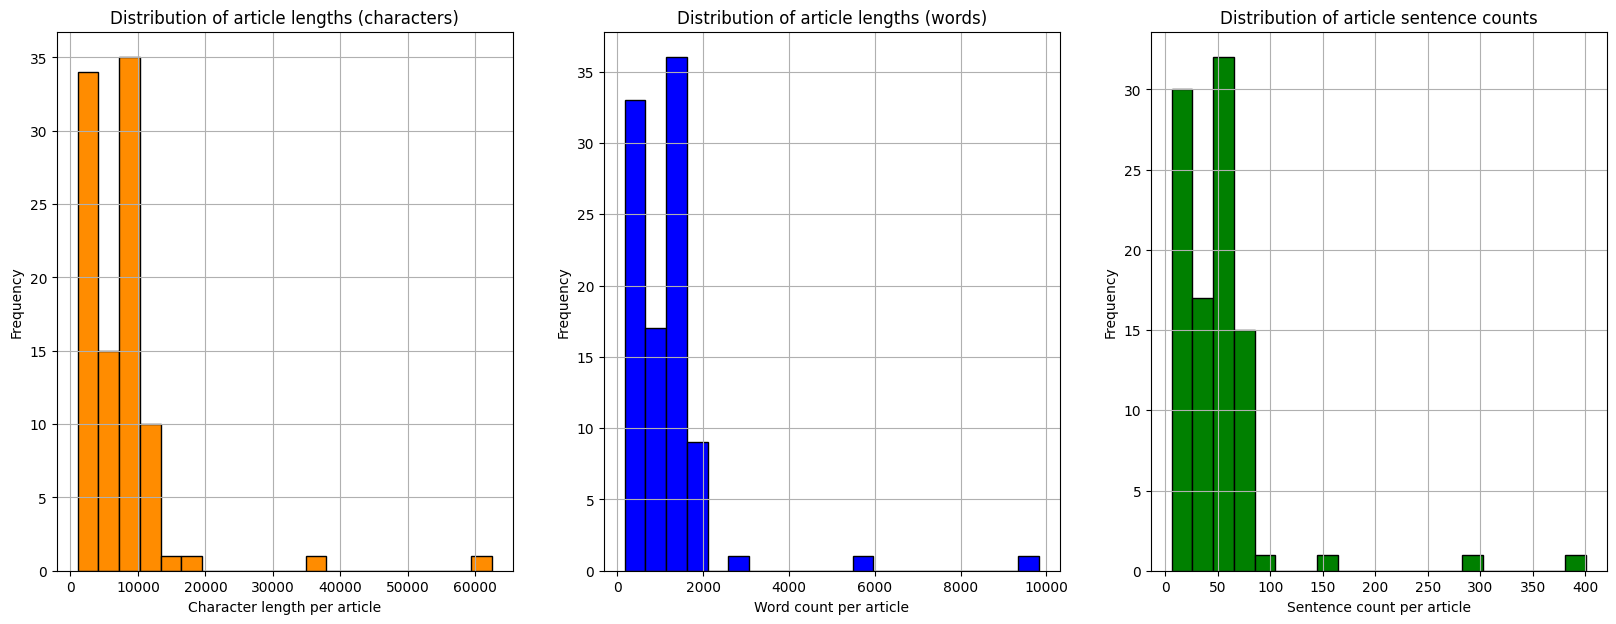

In [8]:
plt.figure(figsize=(20, 7))

# 1. Word count
plt.subplot(1, 3, 2)
df['word_count'].hist(bins=20, color='blue', edgecolor='black')
plt.xlabel('Word count per article')
plt.ylabel('Frequency')
plt.title('Distribution of article lengths (words)')

# 2. Character count
plt.subplot(1, 3, 1)
df['char_len'].hist(bins=20, color='darkorange', edgecolor='black')
plt.xlabel('Character length per article')
plt.ylabel('Frequency')
plt.title('Distribution of article lengths (characters)')

# 3. Sentence count
plt.subplot(1, 3, 3)
df['sent_count'].hist(bins=20, color='green', edgecolor='black')
plt.xlabel('Sentence count per article')
plt.ylabel('Frequency')
plt.title('Distribution of article sentence counts')

plt.show()

<div class="alert alert-block alert-success">
<b>Logical Explanation:</b> 

* Most AI news articles fall between **500-1500 words**, showing that they are typically long, detailed pieces rather than short updates.
* A few articles are significantly longer, reaching **6000-9500 words (280-400 Sentences)**, which indicates the presence of deep-dive research.
* The character length distribution mirrors words and sentence pattern, with most articles clustering between **3000-10000 characters** and a few extreme outliers above **35000 characters**.
* Overall, the dataset provides a rich mix of medium, and very long AI articles—ideal for testing summarization models and ROUGE evaluation across varying content lengths.
</div>

In [9]:
# Marking long outliers
df['is_long_outlier'] = df['word_count'] > 5000    

#Checking how many outliers we have
print("Long outliers:", df['is_long_outlier'].sum())

# Optional: view them
df[df['is_long_outlier']][['title', 'word_count']].head() 

Long outliers: 2


,title,word_count
88,A comprehensive list of 2025 tech layoffs,5880
89,ChatGPT: Everything you need to know about the...,9830


<div class="alert alert-block alert-success">
<b>Logical Explanation:</b> 

* Two articles in the dataset are much longer than the rest, so I will mark them as outliers to handle them separately during summarization instead of removing them entirely.
* I am Labeling these long texts to ensures I can chunk them later if required while still keeping valuable content for ROUGE evaluation and sentiment analysis.
* My idea is if my summarizer struggles with extreme long text thenj I can chunk those separately.

In [10]:
# Stopword removal 
STOPWORDS = set(stopwords.words('english'))

In [11]:
def simple_tokenize(text):
    text = str(text).lower()
    # Keep only letters and spaces
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = text.split()
    return tokens

all_tokens = []
for doc in df['content']:
    all_tokens.extend(simple_tokenize(doc))

# Very simple stopword list (you can extend later)
STOPWORDS = set(stopwords.words('english'))

filtered_tokens = [t for t in all_tokens if t not in STOPWORDS]
counter = Counter(filtered_tokens)
print(counter.most_common(10))

[('ai', 737), ('data', 527), ('model', 512), ('new', 356), ('models', 335), ('openai', 329), ('chatgpt', 279), ('company', 260), ('like', 256), ('using', 235)]


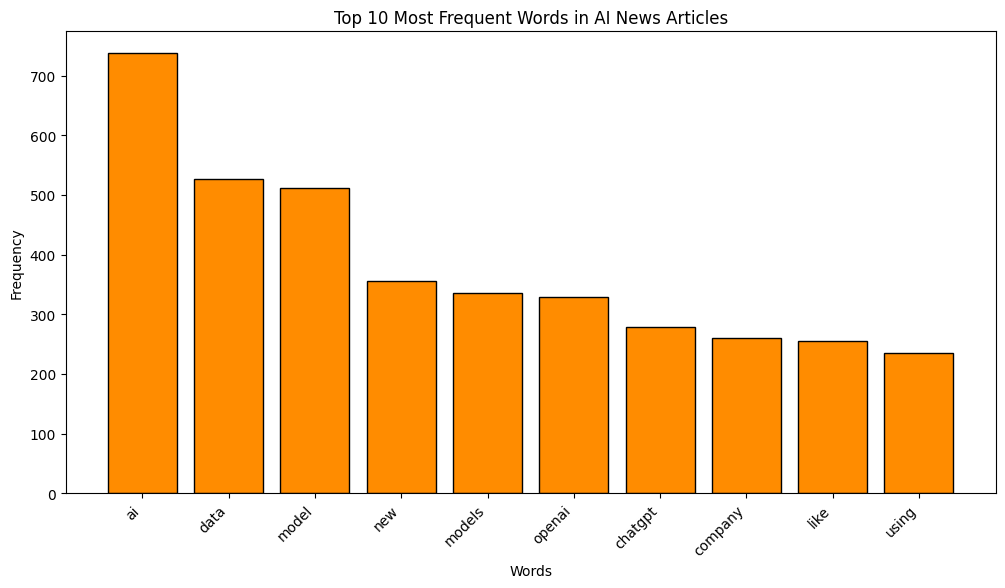

In [12]:
# Visualising top 10 repeating words
TOP_N = 10
top_words = counter.most_common(TOP_N)

# Separate words and counts for plotting
words = [w for w, c in top_words]
counts = [c for w, c in top_words]

plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='darkorange', edgecolor='black')

plt.xticks(rotation=45, ha='right')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title(f"Top {TOP_N} Most Frequent Words in AI News Articles")

plt.show()

<div class="alert alert-block alert-success">
<b>Logical Explanation:</b> 

* Most articles focus on core AI topics like ai, data, and model(s), showing the content is mainly technical.
* Words like OpenAI and ChatGPT appear often, meaning many articles cover major companies and their AI products.
</div>

In [13]:
summary_len = 150  # target words per summary
df['compression_ratio'] = summary_len / df['word_count']

print(df['compression_ratio'].describe())

count    98.000000
mean      0.212442
std       0.157406
min       0.015259
25%       0.107585
50%       0.133991
75%       0.287911
max       0.892857
Name: compression_ratio, dtype: float64


<div class="alert alert-block alert-success">
<b>Logical Explanation:</b> 

* Most articles will need to be compressed to about 10 - 30% of their original length to fit a 150 word summary, which is a reasonable level for informative summarized content.
* A few very short articles require only minimal compression, while the longest articles need much heavier reduction.
* Overall, the dataset provides a good mix of easy and challenging articles, which is useful for testing how well a summarization model handles different lengths.
</div>

In [14]:
def count_sentences(text):
    return len(sent_tokenize(str(text)))

df['sent_count'] = df['content'].apply(count_sentences)
df[['word_count', 'sent_count']].head()

,word_count,sent_count
0,1249,50
1,1361,67
2,1043,48
3,1201,49
4,1524,67


<p style="background-color:#64e3a1; font-family: arial black; color:#000000; font-size: 300%; text-align: center;">Text Summarization: ROUGE Score</p>

<div class="alert alert-block alert-success">
<b>Summarizers: Base models</b> 

* **LexRankSummarizer:** Find the most centeal sentence. This is similar to Google PageRank but for sentences. 
* **LuhnSummarizer:** Count the frequency of important words. This method ignores common stopwords (the, and, or, because).
* **LSASummarizer (Latent Semantic Analysis):** Converts document into big word by sentence matrix. This method picks sentence that represent the strongest semantic topics.
* **TextRankSummarizer:** Like LexRank, but uses weighted word relationships. Sentences are nodes and edges connect sentences with shared important words.

In [15]:
# This dictionary maps method names to SUMY summarizer objects so that we can loop over them easily.

def create_summarizers():
    summarizers = {
        "lexrank": LexRankSummarizer(),
        "luhn": LuhnSummarizer(),
        "lsa": LsaSummarizer(),
        "textrank": TextRankSummarizer(),
    }
    return summarizers

summarizers = create_summarizers()

In [16]:
# Generate 3 sentence extractive summaries for each article and each method 
# For every article in df['content'], we ask each summarizer for 1 key sentence and store it in new columns: summary_lexrank, summary_luhn, summary_lsa, summary_textrank.

def generate_sumy_summaries(df, summarizers, content_col="content", sentences_count=3):
    df = df.copy()
    
    for method_name, summarizer in summarizers.items():
        summaries = []
        for text in df[content_col]:
            if not isinstance(text, str) or not text.strip():
                summaries.append("")
                continue

            parser = PlaintextParser.from_string(text, Tokenizer("english"))
            summary_sentences = summarizer(parser.document, sentences_count=sentences_count)
            summarized = " ".join(str(sent) for sent in summary_sentences)
            summaries.append(summarized)

        df[f"summary_{method_name}"] = summaries

    return df
df = generate_sumy_summaries(df, summarizers)

<div class="alert alert-block alert-success">
<b>Logical Explanation of ROUGE Score</b> 

* **ROUGE-1 (Unigram overlap):** Measures how many single words from the original article appear in the summary.
* **ROUGE-2 (bigram overlap):** Measures overlap of two-word phrases. Harder to match means lower scores.
* **ROUGE-L (Longest Common Subsequence):** Measures how much of the longest coherent sequence of words is shared. This Captures fluency and sentence structure.
* **ROUGE-Lsum:** Like ROUGE-L but optimized for multiple-sentence summaries. Measures structural similarity across an entire summary.

In [17]:
# Checking one example article and its four summaries and ROUGE scores 
# This is to make sure the summaries and scores look reasonable for a single row.

def show_example_with_rouge(df, row_index=0):
    row = df.iloc[row_index]
    content = row["content"]

    print(f"Title: {row.get('title', '(no title column)')}\n")
    print("-" * 80)
    print("ORIGINAL ARTICLE (truncated):\n")
    print(content[:1000], "...\n")  # show first 1000 characters

    scorer = rouge_scorer.RougeScorer(["rouge1", "rougeL"], use_stemmer=True)

    for method in ["lexrank", "luhn", "lsa", "textrank"]:
        summary_col = f"summary_{method}"
        summary = row[summary_col]

        scores = scorer.score(content, summary) #This measures how similar is the summary to the original article. 

        print("=" * 80)
        print(f"{method.upper()} SUMMARY:\n{summary}\n")
        print("ROUGE scores against original:")
        print(f"  ROUGE-1: {scores['rouge1']}")
        print(f"  ROUGE-L: {scores['rougeL']}\n")

# Checking article at the index 10 (Article number 11)
show_example_with_rouge(df, row_index=10)

Title: Accelerating the magic cycle of research breakthroughs and real-world applications

--------------------------------------------------------------------------------
ORIGINAL ARTICLE (truncated):

From earth science to genomics to quantum, we share the latest scientific breakthroughs from Google Research and how today’s powerful AI tools and platforms are accelerating innovation.

Last week at our flagship Research@ event in Mountain View, we shared some of Google Research’s latest announcements, from understanding earth to advancements in genomics to advancements in quantum computing. Working collaboratively with colleagues across the company, our teams drive breakthrough research and accelerate real-world solutions for products, businesses, science and society. As research comes to reality, we uncover new research opportunities, driving innovation further and faster. I call this powerful, cyclical relationship between research and real-world impact the magic cycle of research .

<div class="alert alert-block alert-success">
<b>Explanation:</b> 

* All four classical summarizers achieve perfect precision (1.0) because they copy exact sentences from the article meaning every word they pick also exists in the original text.
* The ROUGE recall is very low, which means the summaries capture only a tiny portion of the full article’s information (they miss most of the content as expected).
* Among the four, TextRank performs slightly better, producing summaries that cover a bit more of the article’s meaning but still far from a complete or balanced representation of the original.

In [18]:
# I will use a distilled BART model that is fast and works very well for English news style articles.

def create_summarizer():
    summarizer = pipeline(
        "summarization",
        model="sshleifer/distilbart-cnn-12-6", 
        tokenizer="sshleifer/distilbart-cnn-12-6",
        device_map="auto",
    )
    return summarizer

summarizer = create_summarizer()

Device set to use cpu


In [19]:
# Below function post processes the output to roughly 150 words.

def summarize_to_150_words(text, target_words=150):
    if not isinstance(text, str) or not text.strip():
        return ""
    shortened = text.strip()
    if len(shortened) > 4000:
        shortened = shortened[:4000]

    # Running model summarizer
    result = summarizer(
        shortened,
        max_length=256,   
        min_length=80,  
        do_sample=False,  
        truncation=True,
    )

    summary_text = result[0]["summary_text"].strip()

    # Post-process
    words = summary_text.split()
    if len(words) > target_words:
        words = words[:target_words]
        summary_text = " ".join(words)

    return summary_text

In [20]:
# Below function creates a new column 'summary_llm_150words' with around 150-word abstractive summaries.

def add_llm_summaries(df, content_col="content", summary_col="summary_llm_150words"):
    summaries = []
    for i, text in enumerate(df[content_col]):
        print(f"Summarizing article {i+1}/{len(df)}...", end="\r")
        summary = summarize_to_150_words(text)
        summaries.append(summary)
    df[summary_col] = summaries
    print("\nDone generating LLM summaries.")
    return df

df = add_llm_summaries(df)

Your max_length is set to 256, but your input_length is only 248. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=124)


Summarizing article 98/98...
Done generating LLM summaries.


In [21]:
# Checking how good is LLM generated summary compared to the original one!
def show_example_article_and_summary(df, idx=0, summary_col="summary_llm_150words"):
    row = df.iloc[idx]
    print(f"Title: {row.get('title', '(no title)')}\n")
    print("=" * 80)
    print("ORIGINAL ARTICLE (truncated):\n")
    print(row["content"][:1200], "...\n")  # show first 1200 chars
    print("=" * 80)
    print("LLM SUMMARY (~150 words):\n")
    print(row[summary_col])

# Checking first article
show_example_article_and_summary(df, idx=0)

Title: Reducing EV range anxiety: How a simple AI model predicts port availability

ORIGINAL ARTICLE (truncated):

We developed a unique model to predict the probability with which an EV charging port will be available at a certain station within a certain amount of minutes from the current time, which helps EV drivers plan their trips efficiently while minimizing waiting time at the charging stations.

The transition to electric vehicles (EVs) is accelerating globally, bringing with it the critical need for a reliable and robust charging infrastructure. While building out more physical charging stations is an important step, an equally important task is maximizing the efficiency of this infrastructure and minimizing "range anxiety”, a term used to describe an EV driver’s fear of running out of battery before reaching their destination or the nearest available charging station. These concerns led us to design an approach for EV routing that reduces range anxiety by integrating charging

In [22]:
# This is useful for comparing classical vs LLM summaries, and use it for sentiment analysis.

df.to_csv("data/combined_AI_articles_with_summaries.csv", index=False) #I already downloaed file so commenting incase I re-rin in future
print("Saved: combined_AI_articles_with_summaries.csv")

Saved: combined_AI_articles_with_summaries.csv


In [23]:
# Below function computes ROUGE scores for all summarization methods (LexRank, Luhn, LSA, TextRank, LLM 150-word) on every article and returns a tidy DataFrame that is easy to analyze and plot.

def compute_rouge_for_all_methods(
    df,
    content_col="content",
    method_to_summary_col=None,
    metrics=("rouge1", "rouge2", "rougeL", "rougeLsum"),
):
    if method_to_summary_col is None:
        method_to_summary_col = {
            "lexrank": "summary_lexrank",
            "luhn": "summary_luhn",
            "lsa": "summary_lsa",
            "textrank": "summary_textrank",
            "llm_150": "summary_llm_150words",
        }

    scorer = rouge_scorer.RougeScorer(list(metrics), use_stemmer=True)

    records = []

    for idx, row in df.iterrows():
        original = row[content_col]
        if not isinstance(original, str) or not original.strip():
            continue

        for method, summary_col in method_to_summary_col.items():
            summary = row.get(summary_col, "")
            if not isinstance(summary, str) or not summary.strip():
                # If no summary, just record zeros
                for metric in metrics:
                    records.append({
                        "index": idx,
                        "method": method,
                        "metric": metric,
                        "f1": 0.0
                    })
                continue

            scores = scorer.score(original, summary)
            for metric in metrics:
                records.append({
                    "index": idx,
                    "method": method,
                    "metric": metric,
                    "f1": scores[metric].fmeasure
                })

    rouge_df = pd.DataFrame(records)
    return rouge_df

rouge_df = compute_rouge_for_all_methods(df)
rouge_df.head()

,index,method,metric,f1
0,0,lexrank,rouge1,0.110448
1,0,lexrank,rouge2,0.107623
2,0,lexrank,rougeL,0.110448
3,0,lexrank,rougeLsum,0.110448
4,0,luhn,rouge1,0.197865


<div class="alert alert-block alert-success">
<b>Explanation:</b> 

* The table shows how well each summarizer keeps the original article’s content using ROUGE F1 scores.
* Each row represents one article, one summarizer, and one ROUGE metric (rouge1, rouge2, rougeL, rougeLsum).
* For example, LexRank (index 0, first article) scores about 0.11 on ROUGE-1, meaning it captures roughly 11% of the original wording.
* Luhn (index 0) performs better with a ROUGE-1 score of around 0.198, showing it matches more of the original content than LexRank.

In [24]:
# Below function builds a clean comparison table of average ROUGE scores for each method and each metric (ROUGE-1, ROUGE-2, ROUGE-L, ROUGE-Lsum).

def build_average_rouge_table(rouge_df):
    avg_table = (
        rouge_df
        .groupby(["method", "metric"])["f1"]
        .mean()
        .reset_index()
        .pivot(index="method", columns="metric", values="f1")
    )

    # Sort methods in a nice order
    desired_order = ["lexrank", "luhn", "lsa", "textrank", "llm_150"]
    avg_table = avg_table.reindex(desired_order)
    return avg_table

avg_rouge_table = build_average_rouge_table(rouge_df)
print("Average ROUGE F1 scores by method:")
display(avg_rouge_table.round(4))


Average ROUGE F1 scores by method:


metric,rouge1,rouge2,rougeL,rougeLsum
method,,,,
lexrank,0.1798,0.1741,0.1798,0.1798
luhn,0.2457,0.2407,0.2457,0.2457
lsa,0.1741,0.1682,0.1741,0.1741
textrank,0.2425,0.2374,0.2425,0.2424
llm_150,0.1730,0.1554,0.1592,0.1704


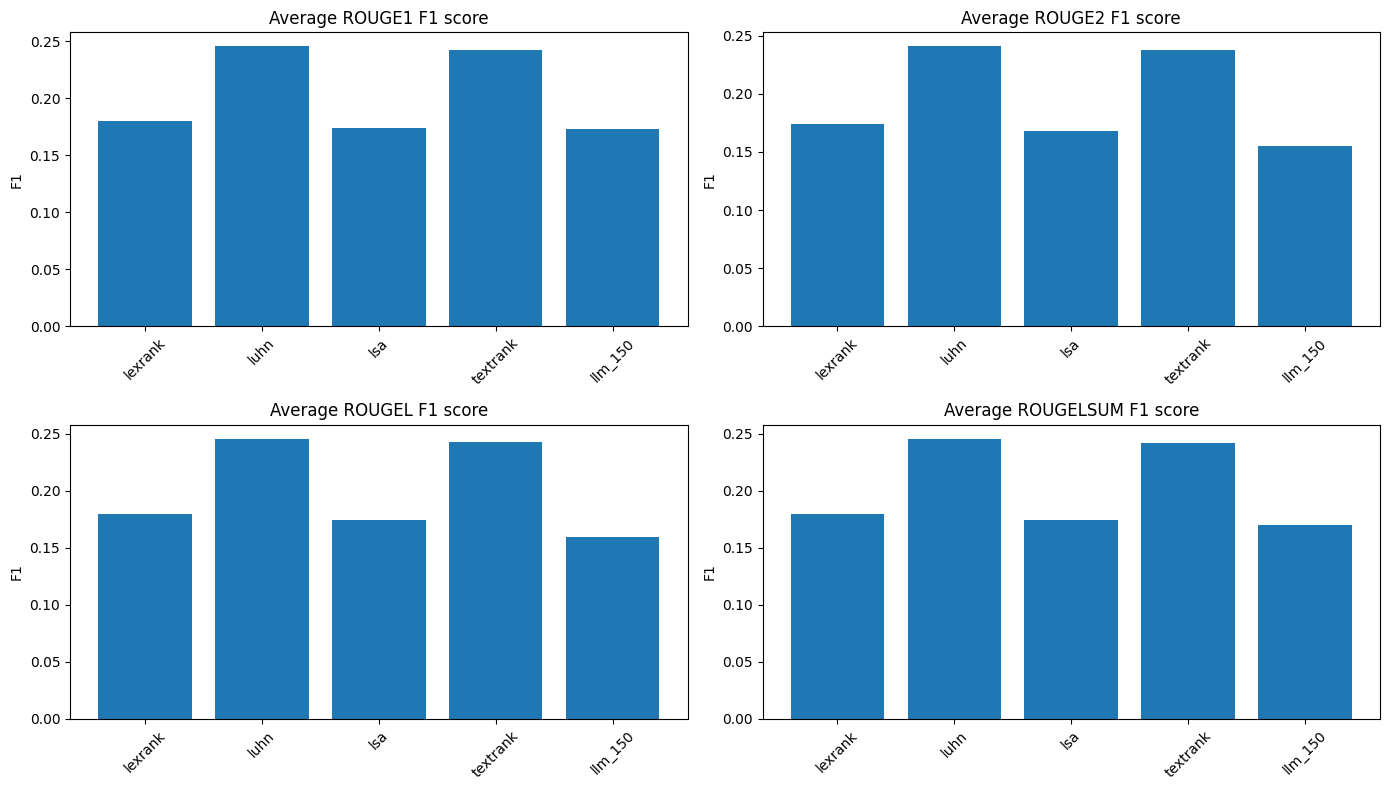

In [25]:
# This block plots a separate bar chart for each ROUGE metric to visually compare how each method performs, especially LLM vs classic

def plot_avg_rouge_bars(avg_table):
    metrics = list(avg_table.columns)
    methods = list(avg_table.index)

    plt.figure(figsize=(14, 8))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        values = avg_table[metric].values
        plt.bar(methods, values)
        plt.title(f"Average {metric.upper()} F1 score")
        plt.ylabel("F1")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

plot_avg_rouge_bars(avg_rouge_table)


<div class="alert alert-block alert-success">
<b>Result Analysis:</b> 

* Luhn and TextRank give the strongest summaries, scoring around 0.24 ROUGE-1 F1 on average, meaning they capture around 24% of the key words from the original articles.
* LexRank and LSA perform moderately, with ROUGE-1 F1 scores near 0.18, showing they captures less information compared to the Luhn and TextRank.
* The LLM_150 word summaries score the lowest (0.17 ROUGE-1 F1) because ROUGE penalizes paraphrasing, even though the LLM produces more fluent, richer summaries than classical methods.

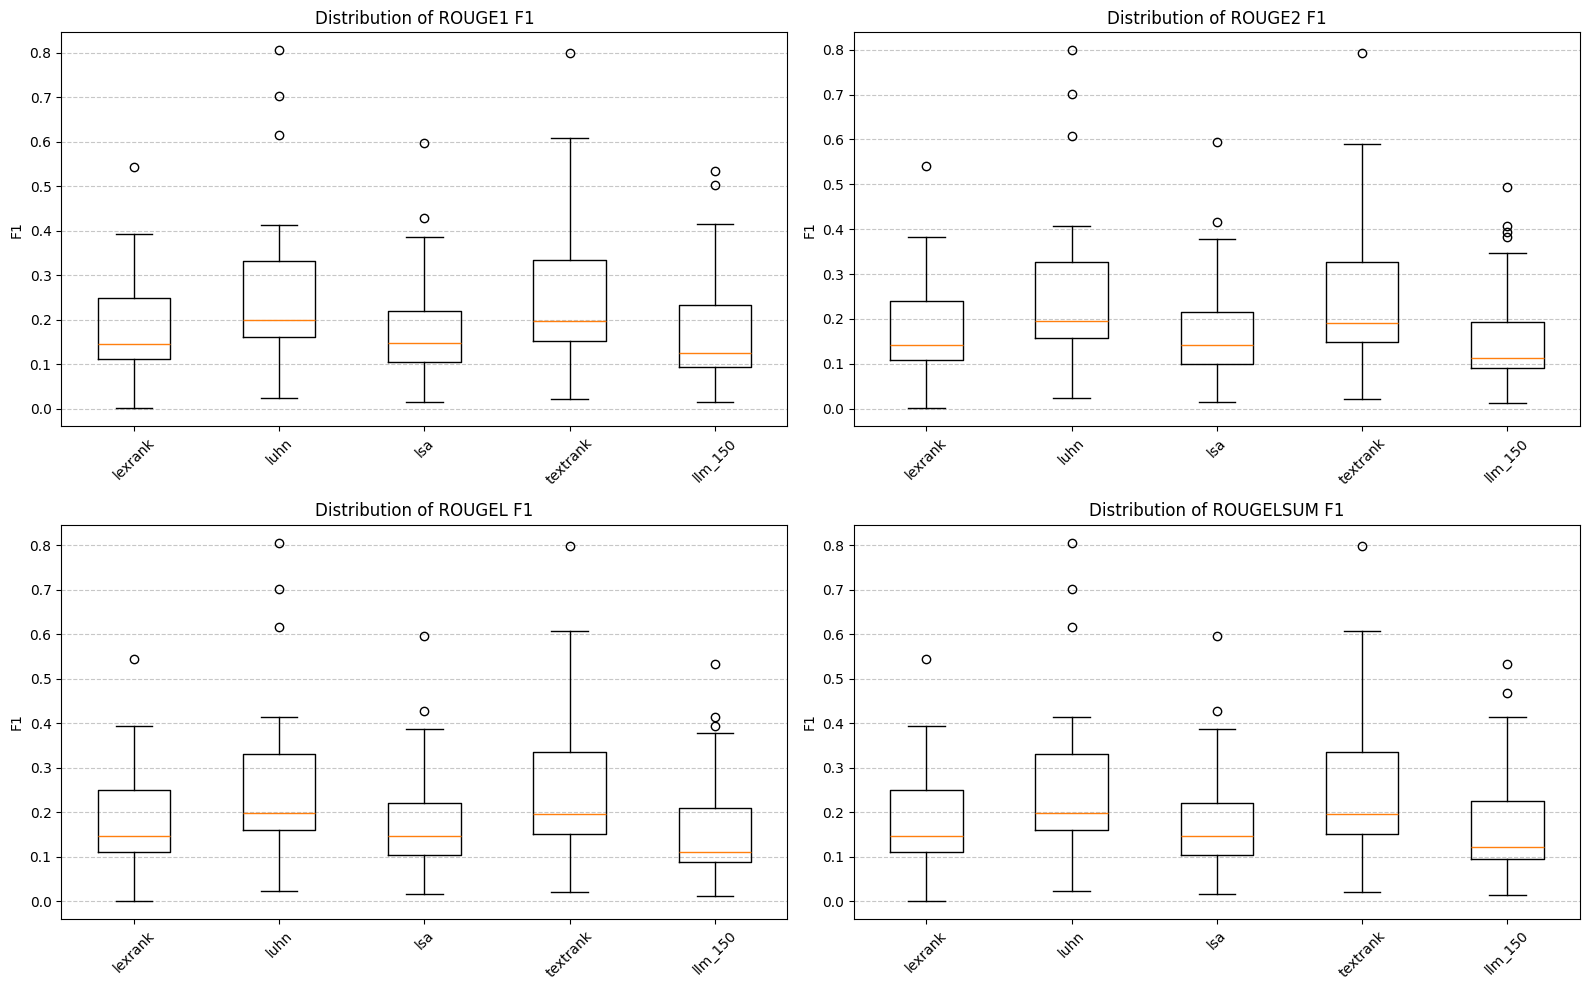

In [26]:
# This function creates boxplots for each ROUGE metric, showing how scores are distributed across articles for each method.

def plot_rouge_boxplots(rouge_df):
    metrics = rouge_df["metric"].unique()
    methods = ["lexrank", "luhn", "lsa", "textrank", "llm_150"]

    plt.figure(figsize=(16, 10))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)

        data = []
        labels = []
        for m in methods:
            vals = rouge_df[(rouge_df["method"] == m) & (rouge_df["metric"] == metric)]["f1"].values
            if len(vals) > 0:
                data.append(vals)
                labels.append(m)

        plt.boxplot(data, tick_labels=labels)
        plt.title(f"Distribution of {metric.upper()} F1")
        plt.ylabel("F1")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

plot_rouge_boxplots(rouge_df)

<div class="alert alert-block alert-success">
<b>Result Analysis:</b> 

* The boxplots show that all summarizers have a wide spread of ROUGE scores, meaning their performance varies a lot depending on the article’s complexity and structure.
* Luhn and TextRank not only achieve higher median scores but also show greater variability, indicating they perform good on some articles but not so good on others.
* LLM_150 has the most stable but lowest range, which means it produces consistent summaries but gets penalized by ROUGE because it paraphrases heavily instead of copying text.
* Extractive methods like LexRank, Luhn, and TextRank have more outliers, suggesting that for certain articles, they capture significantly more overlapping phrases than usual due to short content in articles.

In [27]:
# Below function adds useful length based metrics to df and allows to relate them to ROUGE scores.

def add_length_and_compression(df, original_col="content", summary_col="summary_llm_150words"):
    df["orig_words"] = df[original_col].astype(str).str.split().str.len()
    df["llm_words"] = df[summary_col].astype(str).str.split().str.len()
    df["llm_compression_ratio"] = df["llm_words"] / df["orig_words"]
    return df

df = add_length_and_compression(df)

df[["orig_words", "llm_words", "llm_compression_ratio"]].describe()

,orig_words,llm_words,llm_compression_ratio
count,98.000000,98.000000,98.000000
mean,1140.989796,73.428571,0.103653
std,1137.333022,9.665541,0.074562
min,168.000000,58.000000,0.007528
25%,521.000000,67.000000,0.050984
50%,1119.500000,72.000000,0.068696
75%,1394.250000,76.000000,0.137587
max,9830.000000,109.000000,0.381910


<div class="alert alert-block alert-success">
<b>Result Analysis:</b> 

* The original articles are quite long, averaging **around 1140 words**, while the LLM summaries average only **73 words**, showing a strong reduction in length.
* The **LLM compression ratio is very low (0.10 on average)**, meaning the model condenses articles to about **10% of their original size**.
* Compression varies widely across articles (from **0.007 to 0.38**), which shows that the LLM sometimes produces extremely short summaries and sometimes retains more detail depending on the article’s complexity.

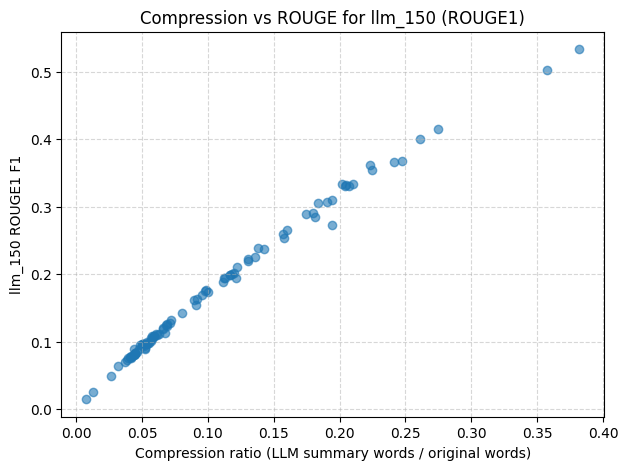

In [28]:
# Below function explores how LLM summarization compression relates to ROUGE-1.

def plot_compression_vs_rouge(rouge_df, df, method="llm_150", metric="rouge1"):
    # Merge ROUGE scores for chosen method+metric back onto df by index
    sub = rouge_df[(rouge_df["method"] == method) & (rouge_df["metric"] == metric)][["index", "f1"]]
    merged = df.merge(sub, left_index=True, right_on="index", how="inner")

    plt.figure(figsize=(7, 5))
    plt.scatter(merged["llm_compression_ratio"], merged["f1"], alpha=0.6)
    plt.xlabel("Compression ratio (LLM summary words / original words)")
    plt.ylabel(f"{method} {metric.upper()} F1")
    plt.title(f"Compression vs ROUGE for {method} ({metric.upper()})")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

plot_compression_vs_rouge(rouge_df, df, method="llm_150", metric="rouge1")

<div class="alert alert-block alert-success">
<b>Result Analysis for Scatter plot (Above) and below result</b> 

* The scatterplot shows a strong positive relationship between the LLM’s compression ratio and ROUGE-1 scores, suggesting the LLM earns higher ROUGE scores when it produces longer summaries that retain more words from the original text.
* Extremely short summaries (compression below 0.05) consistently get very low ROUGE-1 scores, confirming that ROUGE penalizes heavily compressed, highly paraphrased LLM outputs.
  
* The ranking table below shows that Luhn and TextRank achieve the best ROUGE-1 and ROUGE-L scores, mainly because they copy more sentences directly from the articles.
* The LLM 150 word model ranks last in ROUGE, not because it produces worse summaries, but because ROUGE favors extractive methods, while the LLM generates more abstract, paraphrased summaries that overlap less at the word level.

In [29]:
# This Below function shows ranking of methods by ROUGE-1 and ROUGE-L.

def print_method_rankings(avg_table):
    for metric in ["rouge1", "rougeL"]:
        print(f"\nRanking by average {metric.upper()} F1:")
        ranked = avg_table[metric].sort_values(ascending=False)
        for i, (method, score) in enumerate(ranked.items(), start=1):
            print(f"  {i}. {method:9s} -> {score:.4f}")

print_method_rankings(avg_rouge_table)


Ranking by average ROUGE1 F1:
  1. luhn      -> 0.2457
  2. textrank  -> 0.2425
  3. lexrank   -> 0.1798
  4. lsa       -> 0.1741
  5. llm_150   -> 0.1730

Ranking by average ROUGEL F1:
  1. luhn      -> 0.2457
  2. textrank  -> 0.2425
  3. lexrank   -> 0.1798
  4. lsa       -> 0.1741
  5. llm_150   -> 0.1592


<div class="alert alert-block alert-warning">
<b>Note!</b> 

* BERTScore is better for evaluating LLM summaries because it measures semantic meaning rather than exact word overlap.   
* ROUGE is still useful as a baseline, but it tends to undervalue high quality LLM summaries that use different wording.
</div>

<p style="background-color:#64e3a1; font-family: arial black; color:#000000; font-size: 300%; text-align: center;">Text Summarization: BERTScore</p>

In [30]:
method_to_summary_col = {
    "lexrank":  "summary_lexrank",
    "luhn":     "summary_luhn",
    "lsa":      "summary_lsa",
    "textrank": "summary_textrank",
    "llm_150":  "summary_llm_150words",
}

In [31]:
# Compute BERTScore (P, R, F1) for all methods and all articles
# This function loops over each summarization method, collects valid (ref, summary) pairs, runs BERTScore in batch, and returns a tidy DataFrame with scores.

def compute_bertscore_for_methods(
    df,
    method_to_summary_col,
    content_col="content",
    lang="en",
    model_type="bert-base-uncased",
):
    # Decide whether to use GPU or CPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    records = []

    for method, summary_col in method_to_summary_col.items():
        print(f"\nComputing BERTScore for method: {method}")

        refs = []
        cands = []
        idxs = []

        # Collect all valid reference–candidate pairs
        for idx, row in df.iterrows():
            ref = row[content_col]
            cand = row.get(summary_col, "")

            if (
                isinstance(ref, str) and ref.strip() and
                isinstance(cand, str) and cand.strip()
            ):
                refs.append(ref)
                cands.append(cand)
                idxs.append(idx)

        if not refs:
            print(f"  No valid data for method '{method}', skipping.")
            continue

        # Run BERTScore in batch for this method
        P, R, F1 = bertscore_score(
            cands,
            refs,
            lang=lang,
            model_type=model_type,
            device=device,
            verbose=True,
        )

        # Store results
        for i, idx in enumerate(idxs):
            records.append({
                "index": idx,
                "method": method,
                "P": float(P[i]),
                "R": float(R[i]),
                "F1": float(F1[i]),
            })

    berts_df = pd.DataFrame(records)
    return berts_df

berts_df = compute_bertscore_for_methods(df, method_to_summary_col)
berts_df.head()


Using device: cpu

Computing BERTScore for method: lexrank
calculating scores...
computing bert embedding.


100%|██████████| 4/4 [01:52<00:00, 28.05s/it]


computing greedy matching.


100%|██████████| 2/2 [00:00<00:00,  5.18it/s]


done in 112.62 seconds, 0.87 sentences/sec

Computing BERTScore for method: luhn
calculating scores...
computing bert embedding.


100%|██████████| 4/4 [01:54<00:00, 28.67s/it]


computing greedy matching.


100%|██████████| 2/2 [00:00<00:00,  5.67it/s]


done in 115.05 seconds, 0.85 sentences/sec

Computing BERTScore for method: lsa
calculating scores...
computing bert embedding.


100%|██████████| 4/4 [01:55<00:00, 28.83s/it]


computing greedy matching.


100%|██████████| 2/2 [00:00<00:00,  5.10it/s]


done in 115.76 seconds, 0.85 sentences/sec

Computing BERTScore for method: textrank
calculating scores...
computing bert embedding.


100%|██████████| 4/4 [01:42<00:00, 25.62s/it]


computing greedy matching.


100%|██████████| 2/2 [00:00<00:00,  6.64it/s]


done in 102.79 seconds, 0.95 sentences/sec

Computing BERTScore for method: llm_150
calculating scores...
computing bert embedding.


100%|██████████| 4/4 [01:40<00:00, 25.08s/it]


computing greedy matching.


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


done in 100.66 seconds, 0.97 sentences/sec


,index,method,P,R,F1
0,0,lexrank,0.611182,0.493827,0.546273
1,1,lexrank,0.727076,0.615970,0.666928
2,2,lexrank,0.887615,0.630704,0.737424
3,3,lexrank,0.789236,0.532891,0.636212
4,4,lexrank,0.783598,0.571401,0.660884


<div class="alert alert-block alert-warning">
<b>Note!</b> 

Each method generates a different summary. So each summary must be embedded separately.
</div>

In [32]:
# Below function output a table with average BERTScore per method
# This gives us a clean overview of how each summarizer performs on Precision, Recall and F1.

def build_average_bertscore_table(berts_df):
    avg_table = (
        berts_df
        .groupby("method")[["P", "R", "F1"]]
        .mean()
        .sort_values("F1", ascending=False)
    )
    return avg_table

avg_berts_table = build_average_bertscore_table(berts_df)
print("Average BERTScore (P, R, F1) by method:")
display(avg_berts_table.round(4))


Average BERTScore (P, R, F1) by method:


,P,R,F1
method,,,
llm_150,0.8306,0.5635,0.6711
luhn,0.7580,0.5830,0.6575
textrank,0.7407,0.5696,0.6423
lexrank,0.7720,0.5493,0.6401
lsa,0.7259,0.5329,0.6111


<div class="alert alert-block alert-success">
<b>Explanation:</b> 

* The LLM 150-word summaries perform the best, with a BERTScore F1 of 0.6711, meaning they capture the overall meaning of the original articles more accurately than any extractive method.
* Luhn and TextRank follow closely (F1 around 0.6575 and 0.6423), showing they capture a reasonable amount of meaning but still fall short compared to the semantic depth of the LLM summaries.
* LSA scores lowest with an F1 of 0.6118, indicating that its summaries preserve less semantic information across articles compared to the other methods.

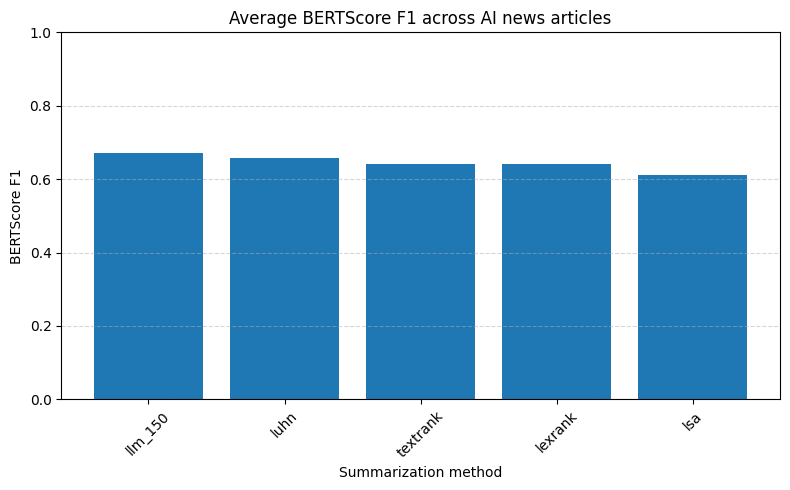

In [33]:
# Visualizing average BERTScore F1 for each method as a bar chart
# This plot makes it easy to see which summarization method is strongest overall by semantic similarity.

def plot_bertscore_f1_bars(avg_table):
    methods = avg_table.index.tolist()
    f1_values = avg_table["F1"].values

    plt.figure(figsize=(8, 5))
    plt.bar(methods, f1_values)
    plt.ylabel("BERTScore F1")
    plt.xlabel("Summarization method")
    plt.title("Average BERTScore F1 across AI news articles")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_bertscore_f1_bars(avg_berts_table)

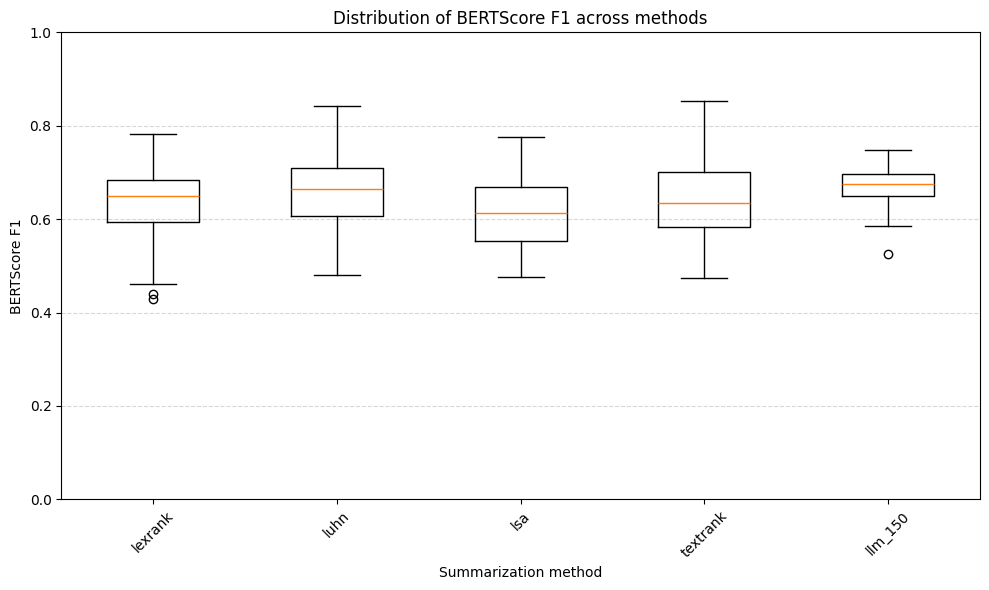

In [34]:
# Boxplots to see the distribution of BERTScore F1 per method.
# This shows not just the average, but how scores spread across all articles for each method.

def plot_bertscore_f1_boxplots(berts_df):
    methods = ["lexrank", "luhn", "lsa", "textrank", "llm_150"]
    data = []

    for m in methods:
        scores = berts_df[berts_df["method"] == m]["F1"].values
        if len(scores) > 0:
            data.append(scores)
        else:
            data.append([0.0])

    plt.figure(figsize=(10, 6))
    plt.boxplot(data, tick_labels=methods)
    plt.ylabel("BERTScore F1")
    plt.xlabel("Summarization method")
    plt.title("Distribution of BERTScore F1 across methods")
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_bertscore_f1_boxplots(berts_df)


<div class="alert alert-block alert-success">
<b>Analysis:</b> 
 
* The LLM_150 summaries are the most consistent, with a tight cluster of BERTScores around 0.65-0.72, meaning the LLM delivers reliably meaningful summaries across almost all articles.
* Classical methods like Luhn and TextRank show larger spreads, indicating that their summary quality varies more depending on the structure or length of each article.
* Extractive methods occasionally hit very high scores above 0.8, but these are outliers, indicating they perform extremely well only on certain articles where copying a few important sentences happens to match the original meaning closely.

<p style="background-color:#64e3a1; font-family: arial black; color:#000000; font-size: 300%; text-align: center;">Text Translation: German</p>

In [35]:
df

,title,link,content,char_len,word_count,sent_count,is_long_outlier,compression_ratio,summary_lexrank,summary_luhn,summary_lsa,summary_textrank,summary_llm_150words,orig_words,llm_words,llm_compression_ratio
0,Reducing EV range anxiety: How a simple AI mod...,https://research.google/blog/reducing-ev-range...,We developed a unique model to predict the pro...,7956,1249,50,False,0.120096,"These “hour feature weights"" are the model's l...",We developed a unique model to predict the pro...,"This model’s simplicity is its strength, allow...","Essentially, the model learns to express the d...",A new model predicts the probability with whic...,1249,84,0.067254
1,Real-time speech-to-speech translation,https://research.google/blog/real-time-speech-...,We introduce an innovative end-to-end speech-t...,9605,1361,67,False,0.110213,We introduce an innovative end-to-end speech-t...,We introduce an innovative end-to-end speech-t...,Today we describe an innovative end-to-end S2S...,The novel architecture leverages a streaming f...,Speech-to-speech translation (S2ST) model enab...,1361,70,0.051433
2,"Generative UI: A rich, custom, visual interact...",https://research.google/blog/generative-ui-a-r...,We introduce a novel implementation of generat...,6688,1043,48,False,0.143816,Today we introduce a novel implementation of g...,Today we introduce a novel implementation of g...,Generative UI capabilities will be rolled out ...,It customizes the experience with an understan...,We introduce a novel implementation of generat...,1043,72,0.069032
3,Separating natural forests from other tree cov...,https://research.google/blog/separating-natura...,Natural Forests of the World 2020 is an AI-pow...,8321,1201,49,False,0.124896,Natural Forests of the World 2020 is an AI-pow...,"In an effort to help meet this need, together ...",A key challenge in conservation efforts is dif...,This project stems from a collaboration with t...,Natural Forests of the World 2020 is an AI-pow...,1201,71,0.059117
4,A new quantum toolkit for optimization,https://research.google/blog/a-new-quantum-too...,New theoretical work from Google Quantum AI sh...,9783,1524,67,False,0.098425,New theoretical work from Google Quantum AI sh...,Very good decoding algorithms have been develo...,"Fortunately, decoding problems have been extre...","In the OPI problem, one is given a list of tar...",New theoretical work from Google Quantum AI sh...,1524,83,0.054462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Ashton Kutcher’s Sound Ventures backs Fei-Fei ...,https://techcrunch.com/2024/10/29/ashton-kutch...,"Ashton Kutcher’s VC firm,\n\nSound Ventures\n\...",2879,486,18,False,0.308642,"The startup, founded by Li, the Stanford profe...",“I don’t know that the existing form factors t...,", co-led by general partners Guy Oseary and Ef...",It aims to develop “large world models” that w...,Ashton Kutcher’s Sound Ventures is investing i...,486,66,0.135802
94,Ashton Kutcher explains why he’s betting on AI...,https://techcrunch.com/2024/10/29/ashton-kutch...,"Ashton Kutcher, co-founder of Sound Ventures, ...",3683,641,19,False,0.234009,He said it’s easy to underestimate how big of ...,“I think a lot of people were afraid of the pe...,He believes that while foundational AI compani...,He said it’s easy to underestimate how big of ...,Ashton Kutcher and Sound Ventures co-founder G...,641,77,0.120125
95,"After selling Anchor to Spotify, co-founders r...",https://techcrunch.com/2024/10/24/after-sellin...,The co-founders who\n\nsold their last startup...,5015,835,30,False,0.179641,"In part, Oboe will rely on third-party foundat...",“This idea is something that Mike and I have b...,Because AI tends to hallucinate or cite bad in...,“This idea is something that Mike and I have b...,New York-based startup Oboe aims to democratiz...,835,67,0.080240
96,"From Goodreads’ founder, Smashing debuts its A...",https://techcrunch.com/2024/10/24/smashing-an-...,"Smashing\n\n, a new app\n\ncurating the b

In [36]:
# I will use the Helsinki-NLP MarianMT model which is fast and good for short summaries.

model_name = "Helsinki-NLP/opus-mt-en-de" 

tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print(f"Using device: {device}")

Using device: cpu


In [37]:
# This function takes a list of texts, runs them through the model in one go, and returns a list of German translations.

def translate_batch_to_german(text_list, max_length=256):
    # Clean up inputs and handle non-string values
    clean_texts = [
        (t if isinstance(t, str) and t.strip() else "")
        for t in text_list
    ]

    if not any(clean_texts):
        return [""] * len(clean_texts)

    enc = tokenizer(
        clean_texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length,
    ).to(device)

    with torch.no_grad():
        generated = model.generate(
            **enc,
            max_length=max_length,
            num_beams=4,
            early_stopping=True,
        )

    decoded = [tokenizer.decode(g, skip_special_tokens=True) for g in generated]
    return decoded

In [38]:
# We translate summaries in small batches so it runs faster and uses less memory.

def add_llm_german_summaries(
    df,
    src_col="summary_llm_150words",
    tgt_col="summary_llm_german",
    batch_size=16,
):
    german_results = []

    # Work in chunks to be efficient
    for start in range(0, len(df), batch_size):
        end = start + batch_size
        batch = df[src_col].iloc[start:end].tolist()
        translated_batch = translate_batch_to_german(batch)
        german_results.extend(translated_batch)

    # Assign new column (aligned with original index)
    df[tgt_col] = german_results[: len(df)]
    return df

df = add_llm_german_summaries(df)
df[["summary_llm_150words", "summary_llm_german"]].head()

,summary_llm_150words,summary_llm_german
0,A new model predicts the probability with whic...,Ein neues Modell prognostiziert die Wahrschein...
1,Speech-to-speech translation (S2ST) model enab...,Speech-to-Speech Translation (S2ST) Modell erm...
2,We introduce a novel implementation of generat...,Wir führen eine neue Implementierung von gener...
3,Natural Forests of the World 2020 is an AI-pow...,Naturwälder der Welt 2020 ist eine KI-powered ...
4,New theoretical work from Google Quantum AI sh...,Neue theoretische Arbeit von Google Quantum AI...


In [39]:
#Translate titles from English to German and store them in 'tgt_col'

def add_german_titles(
    df,
    src_col="title",
    tgt_col="title_german",
    batch_size=32,
    max_length=64,
):
    
    # Making sure target column exists
    if tgt_col not in df.columns:
        df[tgt_col] = ""

    # Indices we actually need to translate
    to_translate_idx = df[
        df[src_col].astype(str).str.strip().ne("") &  # has an English title
        df[tgt_col].astype(str).str.strip().eq("")    # but no German title yet
    ].index

    german_results = {}

    # Work in chunks for memory/speed
    idx_list = list(to_translate_idx)
    for start in range(0, len(idx_list), batch_size):
        batch_idx = idx_list[start:start + batch_size]
        batch_texts = df.loc[batch_idx, src_col].tolist()

        translated_batch = translate_batch_to_german(
            batch_texts,
            max_length=max_length,
            
        )
        
        for i, idx in enumerate(batch_idx):
            german_results[idx] = translated_batch[i]

    # Write back into dataframe
    for idx, de_title in german_results.items():
        df.at[idx, tgt_col] = de_title

    return df

df = add_german_titles(df)

In [40]:
# Quick sanity check
df[["title", "title_german"]].head()

,title,title_german
0,Reducing EV range anxiety: How a simple AI mod...,EV-Bereichsangst reduzieren: Wie ein einfaches...
1,Real-time speech-to-speech translation,Übersetzung von Sprache zu Sprache in Echtzeit
2,"Generative UI: A rich, custom, visual interact...",Generative Benutzeroberfläche: Ein reichhaltig...
3,Separating natural forests from other tree cov...,Trennung von Naturwäldern von anderen Baumbede...
4,A new quantum toolkit for optimization,Ein neues Quanten-Toolkit zur Optimierung


In [41]:
df['summary_llm_german'][1]

'Speech-to-Speech Translation (S2ST) Modell ermöglicht Echtzeit-Übersetzung in der Stimme des ursprünglichen Lautsprechers mit nur einer 2-Sekunden-Verzögerung . Die neuartige Architektur nutzt ein Streaming-Framework und mit dem Training auf zeitsynchronisierten Daten, deutlich reduziert die Verzögerung zwischen dem ursprünglichen Eingang und der übersetzten Sprache . Um eine Vielzahl von Sprachen zu unterstützen, stellen wir eine skalierbare Datenerfassung Pipeline, die es uns ermöglicht, das System schrittweise erweitern, um mehr Sprachen .'

In [42]:
df['summary_llm_150words'][1]

"Speech-to-speech translation (S2ST) model enables real-time translation in the original speaker's voice with only a 2-second delay . The novel architecture leverages a streaming framework and, with training on time-synchronized data, significantly reduces the delay between the original input and the translated speech . To support a breadth of languages, we introduce a scalable data acquisition pipeline that allows us to gradually expand the system to include more languages ."

<div class="alert alert-block alert-warning">
<b>Acknowledgement!</b>

* I would rate above English to German translation just good and not best as I see there are some limitation in capturing the complete meaning (Skiping part of summary; read above output).
* I think this problem can be solved by using a better model (with higher parameters & better performance) but I picked lightweight model, something that my laptop can handle!
</div>

<p style="background-color:#64e3a1; font-family: arial black; color:#000000; font-size: 300%; text-align: center;">Sentiment Analysis</p>

In [43]:
# This DistilBERT model is fine tuned and works nicely for general text like AI news.

model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = 0 if torch.cuda.is_available() else -1  # 0 = first GPU, -1 = CPU

sentiment_pipe = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device,
)

print(f"Using device: {'GPU' if device == 0 else 'CPU'}")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Using device: CPU


In [44]:
# This function takes a list of texts and returns two parallel lists:
# the predicted sentiment labels and their confidence scores.

def run_three_class_sentiment_batch(text_list):
    clean_texts = [
        (t if isinstance(t, str) and t.strip() else "No content.")
        for t in text_list
    ]
    results = sentiment_pipe(clean_texts)
    labels = [r["label"] for r in results]
    scores = [float(r["score"]) for r in results]
    return labels, scores

In [45]:
# This creates 'sentiment' and 'sentiment_score' columns based on summary_llm_150words, then saves the updated dataframe.

def add_three_class_sentiment(
    df,
    text_col="summary_llm_150words",
    label_col="sentiment",
    score_col="sentiment_score",
    batch_size=16,
):
    all_labels = []
    all_scores = []

    for start in range(0, len(df), batch_size):
        end = start + batch_size
        batch = df[text_col].iloc[start:end].tolist()
        labels, scores = run_three_class_sentiment_batch(batch)
        all_labels.extend(labels)
        all_scores.extend(scores)

    df[label_col] = all_labels[: len(df)]
    df[score_col] = all_scores[: len(df)]
    return df

# Applying to existing dataframe 'df'
df = add_three_class_sentiment(df)
# printing first 5 rows
df[["summary_llm_150words", "sentiment", "sentiment_score"]].head()

,summary_llm_150words,sentiment,sentiment_score
0,A new model predicts the probability with whic...,neutral,0.716047
1,Speech-to-speech translation (S2ST) model enab...,neutral,0.575630
2,We introduce a novel implementation of generat...,positive,0.556353
3,Natural Forests of the World 2020 is an AI-pow...,positive,0.650455
4,New theoretical work from Google Quantum AI sh...,neutral,0.510741


<div class="alert alert-block alert-warning">
<b>Note!</b>

* The sentiment_score above represents PROBABILITY.
* The first article (index 0) has the probability of 71.6% of being neutral, while article 3 (index 2) has the probability of 55.6% being positive.
</div>

In [46]:
df['sentiment'].value_counts()

sentiment
neutral     48
positive    42
negative     8
Name: count, dtype: int64

<div class="alert alert-block alert-success">
<b>Key-Take away!</b> 
 
* There are **42** AI news positive articles, **48** neutral articles, and **8** negative sentiment articles.

In [47]:
# Storing DF as CSV
output_path = "data/combined_sentiment.csv"
df.to_csv(output_path, index=False)
print(f"Saved dataframe with sentiment to: {output_path}")

Saved dataframe with sentiment to: data/combined_sentiment.csv


# Conclusion & Future work!